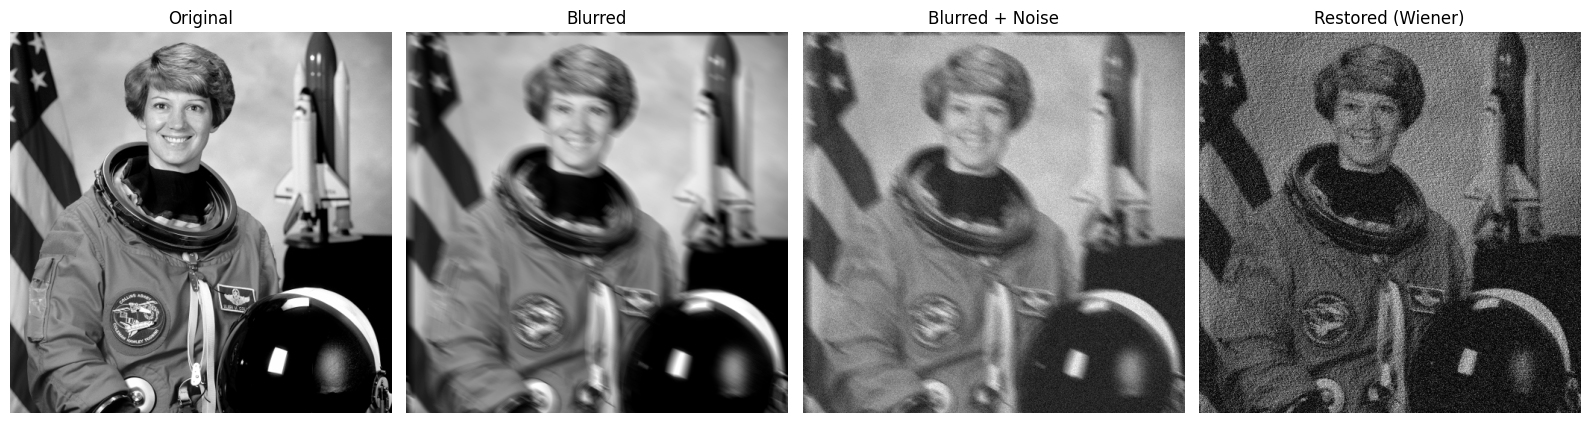

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, data, restoration, img_as_float
from scipy.signal import convolve2d
from numpy.fft import fft2, ifft2, fftshift, ifftshift

# Load example image
image = color.rgb2gray(data.astronaut())
image = img_as_float(image)

# Simulate PSF (Point Spread Function): motion blur
def motion_blur_psf(length, angle, shape):
    psf = np.zeros(shape)
    center = (shape[0] // 2, shape[1] // 2)
    for i in range(length):
        offset_x = int(i * np.cos(np.deg2rad(angle)))
        offset_y = int(i * np.sin(np.deg2rad(angle)))
        psf[center[0] + offset_y, center[1] + offset_x] = 1
    psf /= psf.sum()
    return psf

psf = motion_blur_psf(length=15, angle=30, shape=image.shape)

# Degrade image: convolution with PSF
blurred = convolve2d(image, psf, mode='same', boundary='wrap')

# Now calculate the OTF (Optical Transfer Function = FFT of PSF)
otf = fft2(ifftshift(psf))

# Add some noise
np.random.seed(0)
noisy = blurred + 0.05 * np.random.standard_normal(image.shape)

# Wiener filter implementation using OTF
def wiener_filter(degraded, otf, K):
    degraded_fft = fft2(degraded)
    otf_conj = np.conj(otf)
    otf_abs2 = np.abs(otf)**2
    wiener_fft = (otf_conj / (otf_abs2 + K)) * degraded_fft
    restored = np.abs(ifft2(wiener_fft))
    return restored

# Apply Wiener filter
K = 0.01  # noise-to-signal power ratio (tune this parameter)
restored = wiener_filter(noisy, otf, K)

# Display results
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(blurred, cmap='gray')
axes[1].set_title("Blurred")
axes[1].axis('off')

axes[2].imshow(noisy, cmap='gray')
axes[2].set_title("Blurred + Noise")
axes[2].axis('off')

axes[3].imshow(restored, cmap='gray')
axes[3].set_title("Restored (Wiener)")
axes[3].axis('off')

plt.tight_layout()
plt.show()
